<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Variational_autoencoders_credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 26th October, 2023
#               VijayDashmi

# Variational Autoencoder

In [ ]:
# 0.0
%reset -f

In [1]:
# 1.0 Python ≥3.5 is required

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler


# 1.0.2 TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1.0.3 Common imports
import numpy as np
import pandas as pd
import os,time


# 1.0.4 To plot pretty figures
import matplotlib.pyplot as plt

In [2]:
# 1.0.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# 2.0
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# 2.1
pathToFolder= "/gdrive/MyDrive/Colab_data_files/creditcard/"
file = "creditcardfraud.zip"

In [5]:
# 2.2 Read file:
raw_data = pd.read_csv(pathToFolder + file)
raw_data.shape  # (284807, 31)

(284807, 31)

In [6]:
# 2.3
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Some rough work

In [ ]:
# Time appears to be in seconds:

raw_data['Time'].max()  # 172792.0

In [14]:
x = 3700/3600 % 24
x   # Converts to hours scale 1.0277777777777777

1.0277777777777777

In [17]:
x = ((12 * 3600) + 100)
x

43300

In [19]:
x/3600 %24   # 12.027777777777779

12.027777777777779

## Split data

In [12]:
# 3.0
data, data_test = train_test_split(raw_data,
                                   test_size=0.25
                                   )

We transform the Time field to time-of-day to account for intraday seasonality. The Amount field is transformed to log scale, with the intuition that the scale of magnitute of a transaction could be a more relevant feature for fraud than linear amounts.

In [ ]:
# 3.1
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

# 3.1.1
data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
36117,10.667778,-0.438698,0.551577,1.361523,0.854082,-0.005587,0.041740,0.459717,-0.081897,0.828238,...,0.029011,0.333867,-0.008788,0.033044,-0.531050,-0.473284,-0.403109,-0.132423,2.772589,0
222815,15.758056,1.972680,-0.592214,-1.732472,-0.681417,1.819375,3.777885,-1.104536,1.027809,1.120985,...,-0.182669,-0.488718,0.412727,0.657187,-0.390302,-0.601361,0.054708,-0.037361,1.972691,0
273530,22.003056,2.007864,-0.362649,-0.377411,0.322888,-0.778397,-0.796545,-0.549278,-0.009011,1.567407,...,-0.145990,-0.353120,0.353957,-0.211667,-0.399354,-0.911824,0.049215,-0.031706,0.693147,0
6109,1.940833,-2.176673,-1.639549,1.648077,0.541888,2.820718,-2.847391,-0.820157,-0.827410,1.755300,...,-0.570479,-0.387458,-0.602038,0.769497,-1.553510,-0.352912,0.157872,-0.412086,2.399712,0
72759,15.235278,1.216618,0.206324,0.241546,0.447413,-0.522660,-1.531184,0.378456,-0.396944,-0.134747,...,-0.010740,-0.020836,-0.012549,0.999326,0.463289,0.562654,-0.069220,0.012822,3.361417,0


In [ ]:
# 3.2
x = data.drop(["Class"], axis=1)
y = data["Class"].values


In [ ]:
# 3.3 Transform x to numpy and then
#     separate normal vs fraud data:

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]



In [ ]:
x_norm.shape

(213234, 30)

In [ ]:
# 3.4 Sample normal data to size 100000:

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]


In [ ]:
# 3.5 Split sample into train/validation:

x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample,
                                                          test_size=0.2
                                                          )

In [ ]:
# 5.2 Calculate accuracy:

def rounded_accuracy(y_true, y_pred):
    # tf.round(x) rounds the values of x to integer values.
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Given y, I can take a log of it as: log$_{10}$y. Let us say this log is z. Then,  
z = log$_{10}$y  
To get y back from z, I have to raise 10 to the power of z, ie:  
10$^{z}$  ie y = 10$^{z}$  OR log$_{10}$y = z

Therefore, exp(log_var / 2) will give (exp(log σ$^{2}))$$^{0.5}$ or just (σ$^{2}$)$^{0.5}$ or just σ.

## Sampling layer

In [ ]:
# 4.0 Sampling layer
# tf.random_normal: https://www.tensorflow.org/api_docs/python/tf/random/normal

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        out = tf.keras.backend.random_normal(
                            shape = tf.shape(log_var)   # Output random values of given shape
                                                        #  with mean 0 and stdev 1
                            )
        out = out * K.exp(log_var / 2) + mean    # Z * σ + mean
        return out

In [ ]:
# 4.1 latent space size:
codings_size = 2

## Encoder

In [ ]:
# 4.2 encoder

inputs = tf.keras.layers.Input(shape=[x.shape[1]])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(20,
                       activation="selu")(z)

z = tf.keras.layers.Dense(10,
                       activation="selu")(z)

z = tf.keras.layers.Dense(8,
                       activation="selu")(z)

In [ ]:
# 4.2.1 Encoder has two outputs:

codings_mean = tf.keras.layers.Dense(codings_size)(z)
codings_log_var = tf.keras.layers.Dense(codings_size)(z)

In [ ]:
# 4.2.2 And also a IIIRd one derived from above two:

codings = Sampling()([codings_mean, codings_log_var])

In [ ]:
# 4.3 Create encoder. But it outputs three tensors
#     'codings_mean', 'codings_log_var', 'codings'
#     though in the deocder only 'codings' tensor
#     is used.

variational_encoder = tf.keras.models.Model(
                                          inputs=[inputs],
                                          outputs=[codings_mean, codings_log_var, codings]
                                          )

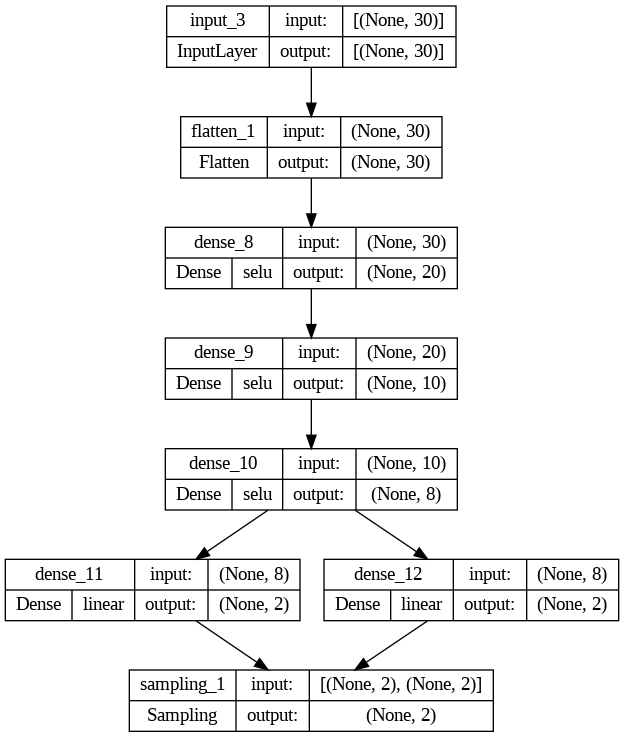

In [ ]:
# 4.4 Plot the encoder model:

tf.keras.utils.plot_model(variational_encoder,
                          show_shapes=True,
                          show_layer_activations=True
                          )

## Decoder model

In [ ]:
# 5.0 For decoder the only input is codings:

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(10, activation="selu")(decoder_inputs)
x = tf.keras.layers.Dense(20, activation="selu")(x)
x = tf.keras.layers.Dense(30, activation="selu")(x)
outputs = x


In [ ]:
# 5.1 Our decoder:
variational_decoder = tf.keras.models.Model(
                                          inputs=[decoder_inputs],
                                          outputs=[outputs]
                                          )


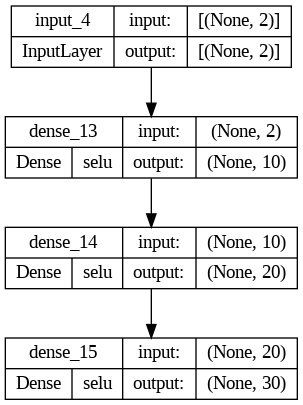

In [ ]:
# 5.2 Decoder plot
tf.keras.utils.plot_model(variational_decoder,
                          show_shapes = True,
                          show_layer_activations=True
                          )

## Variational encoder

In [ ]:
# 6.0 Get decoder output:

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)


In [ ]:
# 6.1
variational_ae = tf.keras.models.Model(
                                    inputs=[inputs],
                                    outputs=[reconstructions]
                                    )

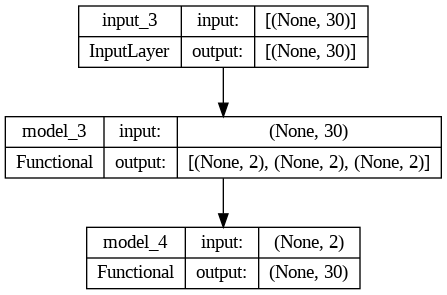

In [ ]:
# 6.2
tf.keras.utils.plot_model(
                          variational_ae,
                          show_shapes= True,
                          show_layer_activations= True
                          )

## Latent loss

In [ ]:
# 7.0 Latent loss is the sum of cross-entropy loss and KL divergence:

latent_loss = -0.5 * tf.keras.backend.sum(
                           1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis=-1
                           )

In [ ]:
# 7.1 Add latent loss during compile time:
variational_ae.add_loss(
                         K.mean(latent_loss) / 30.
                        )

In [ ]:
# 7.2
variational_ae.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=[rounded_accuracy]
                       )

In [ ]:

x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [ ]:
x_norm_train_sample.shape
x_norm_val_sample.shape

(80000, 30)

(20000, 30)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
                               filepath='bestmodel.h5',
                               verbose=0,
                               save_best_only=True
                               )

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                             mode='min',
                             min_delta=0.005,
                             patience=20, verbose=0,
                             restore_best_weights=True
                             )

In [ ]:
start = time.time()
history = variational_ae.fit(x_norm_train_sample,
                             x_norm_train_sample,
                             epochs=1000,
                             batch_size=128,
                             callbacks=[checkpointer, earlystopper],
                             validation_data=(x_norm_val_sample, x_norm_val_sample)
                             )

end = time.time()
print((end-start)/60)

Text(0.5, 1.0, 'latent means')

Text(0, 0.5, 'mean[1]')

Text(0.5, 0, 'mean[0]')

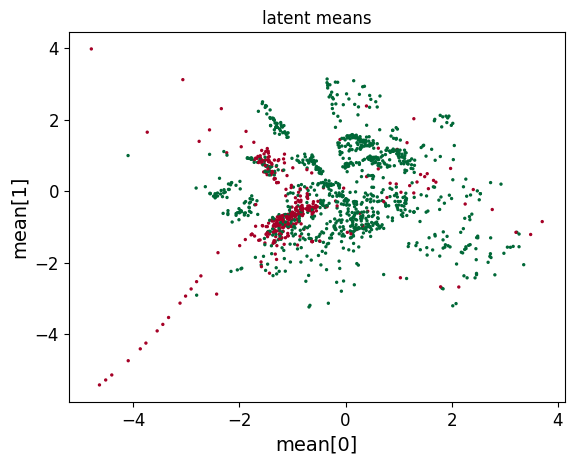

In [ ]:
latent_x_mean = variational_encoder(X)[0].numpy()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

In [ ]:
################